# Práctico 5 - Procesamiento Digital de Imágenes

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import convolve2d
from scipy import ndimage
from scipy.stats import norm
%matplotlib inline

In [2]:
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.596,-0.275,-0.321],
                        [0.211,-0.523, 0.311]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

def rmse(img1, img2):
    return np.sqrt(np.mean((img1-img2)**2))

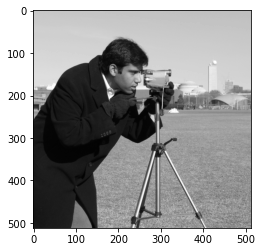

In [3]:
img = imageio.imread('imageio:camera.png')/255
plt.imshow(img, 'gray')

# 1. Filtros convolucionales

Para cada uno de los siguientes incisos implementar una función que devuelva el kernel en función de los parámetros especificados. Luego convolucionar la imagen con el kernel y utilizar la función plot_images_and_kernel() para graficar el resultado.

### 1.1. Implementar los siguientes filtros simétricos (invariantes a la rotación de 90°)

Pasabajos: Los kernels tendrán que ser del tamaño especificado por el usuario. Todos son de NxN donde N es impar.

1. Box (cuadrado) -> params: N
2. Circle (circular) -> params: N
3. Bartlett -> params: N
4. Gaussian -> params: N, std

Pasaaltos:

5. Laplace (4 y 8 vecinos) -> params: neighbors (entero que vale 4 u 8)
6. Pasaaltos a partir de un pasabajos: PA = Id - PB -> params: los mismos que el pasabajos elegido

Pasabanda:

7. Difference of Gaussian (DoG) -> params: N, std1, std2

Otros:

8. Mejora de contraste (combinación del filtro identidad más "un poco" de pasaaltos) -> params: los del pasaaltos y la constante de proporción de pasaaltos sumado

### 1.2. Implementar los siguientes filtros direccionales (asimétricos)

9. Sobel 3x3 -> Calcular valor absoluto de gradientes Gx y Gy y también en módulo y fase. Para graficar la fase, normalizar al rango [0,1] y utilizar un mapa de colores que no sea escala de grises.

### 1.3. Implementar un detector de bordes a partir del filtro de Sobel

Aplicar un umbral al módulo del filtro de Sobel para obtener una imagen binaria con 1s en los bordes y 0s en el resto

### 1.4. Escribir una breve descripción sobre cómo funciona el detector de bordes de Canny

In [4]:
from matplotlib import cm

def plot_kernel(data, ax=None):
    rows, cols = data.shape
    y, x = np.meshgrid(np.arange(rows),np.arange(cols),indexing='ij')
    if ax == None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    _min, _max = (np.min(data), np.max(data))
    ax.plot_surface(x, y, data.T, cmap=cm.jet, vmin=_min, vmax=_max)

def plot_images_and_kernel(img, img_filt, kernel):
    fig = plt.figure(figsize=(17,5))
    ax1 = fig.add_subplot(131)
    ax1.imshow(img, 'gray')
    ax1.title.set_text('Input image')
    ax2 = fig.add_subplot(132)
    ax2.imshow(img_filt, 'gray')
    ax2.title.set_text('Filtered image')
    ax3 = fig.add_subplot(133, projection='3d')
    plot_kernel(kernel, ax=ax3)
    ax3.title.set_text('Kernel')
    plt.show()

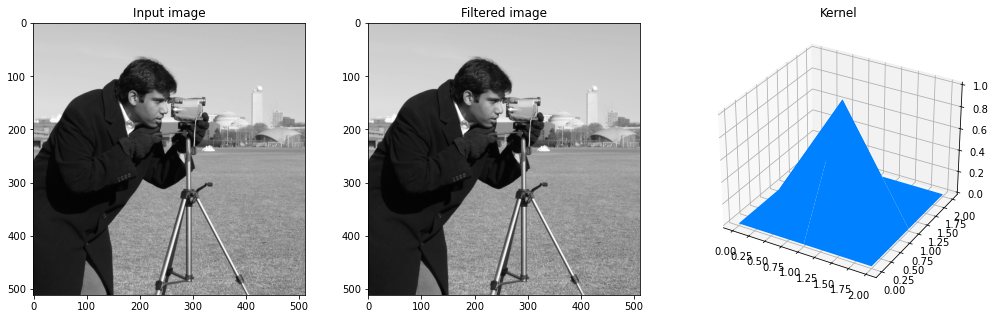

In [5]:
# Ejemplo del kernel identidad
kernel = np.zeros((3,3))
kernel[1,1] = 1
kernel /= kernel.sum()

img_filt = convolve2d(img, kernel, 'same')

plot_images_and_kernel(img, img_filt, kernel)

In [6]:
#Problema 1:

#1.1

#PasaBajos

def filtro_box(N):
    out = np.zeros((N,N))
    out[:,:] = 1
    out /= out.sum()
    return out

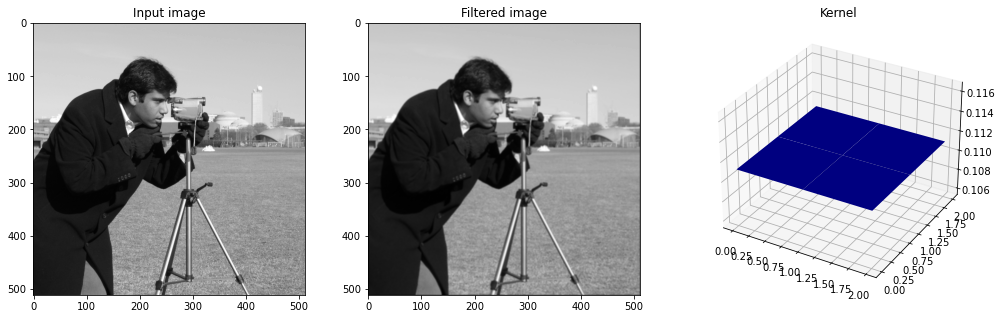

In [7]:
k = filtro_box(3)
img_filt = convolve2d(img,k, 'same')

plot_images_and_kernel(img, img_filt, k)

In [8]:
#Circle (circular) 

def filtro_Circle(N):
    
    r = N//2
    x, y = np.mgrid[-r:r+1, -r:r+1]
    kernel = np.zeros((N, N))
    kernel[x**2 + y**2 <= r**2] = 1
        
    kernel /= kernel.sum()
    return kernel

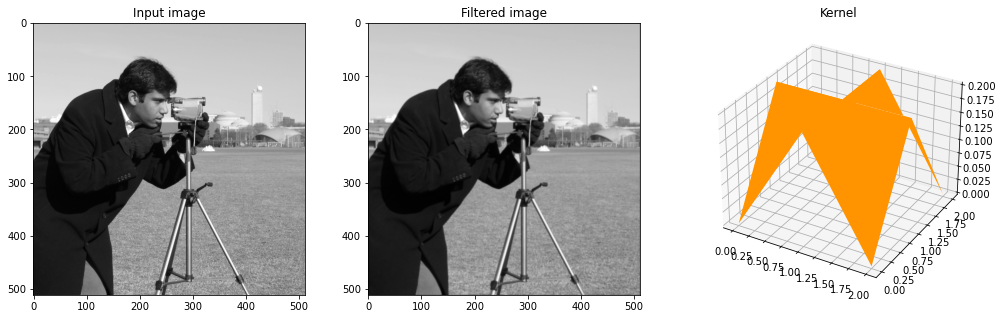

In [9]:
k = filtro_Circle(3)
img_filt = convolve2d(img, k, 'same')

plot_images_and_kernel(img, img_filt, k)

In [10]:
# Bartlett   

def filtro_bartlett(N):    
    
    a = np.bartlett(N)
    a = a*((N-1)/2)+1
    B = np.zeros((1,N))
    C = np.zeros((N,1))
    for i in range (N):
        B [0] [i]= a[i]
        C [i]  [0] = a[i] 
    kernel = np.matmul(C,B)
    kernel /= kernel.sum()
    return kernel

[[0.01234568 0.02469136 0.03703704 0.02469136 0.01234568]
 [0.02469136 0.04938272 0.07407407 0.04938272 0.02469136]
 [0.03703704 0.07407407 0.11111111 0.07407407 0.03703704]
 [0.02469136 0.04938272 0.07407407 0.04938272 0.02469136]
 [0.01234568 0.02469136 0.03703704 0.02469136 0.01234568]]


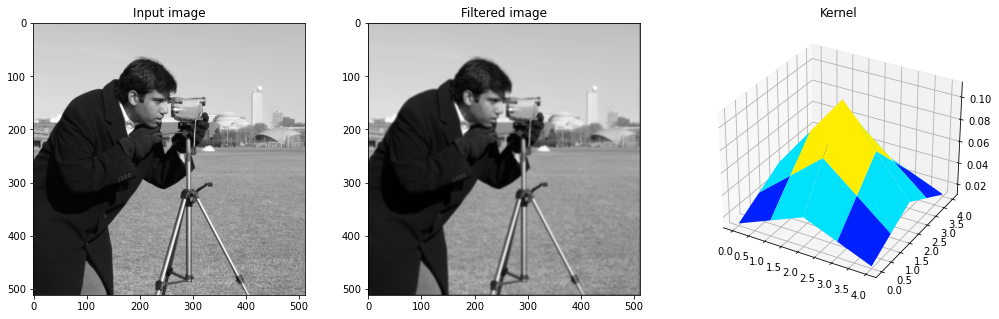

In [89]:
k = filtro_bartlett(5)
print(k)
img_filt = convolve2d(img,k, 'same')

plot_images_and_kernel(img, img_filt, k)

In [12]:
# Gaussian

def filtro_Gaussian(N,std):
    out = np.arange(N)
    out = norm.pdf(out, (N-1)//2,std)
    out = np.outer(out,out)
    out /= out.sum()
    print (out)
    return out

[[0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.03832756 0.05576627 0.06319146 0.05576627 0.03832756]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]]


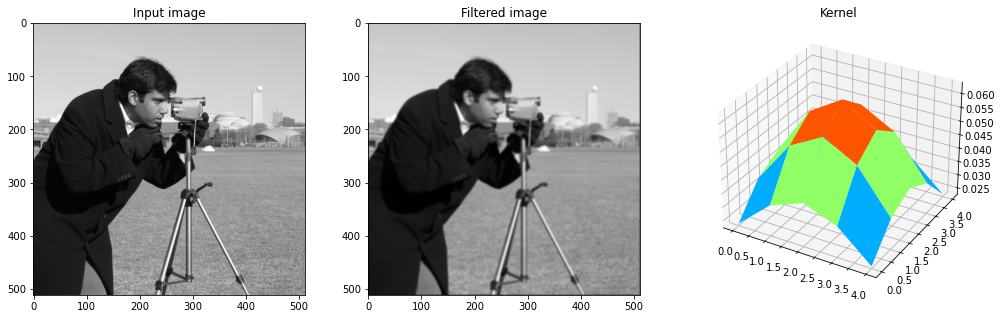

In [13]:
k = filtro_Gaussian(5,2)
img_filt = convolve2d(img, k, 'same')

plot_images_and_kernel(img, img_filt, k)

In [14]:
# PasaAltos  
    
def filtro_laplace(neighbors):
    kernel = np.ones((3,3))
    kernel [:,:]= -1
    
    
    if neighbors==8:
        kernel [2,2] = 8
    
    elif neighbors == 4: 
        kernel[2,2] = 4
        kernel[0,0] = 0
        kernel[0,2] = 0 
        kernel[2,0] = 0 
        kernel[2,2] = 0        
    return kernel

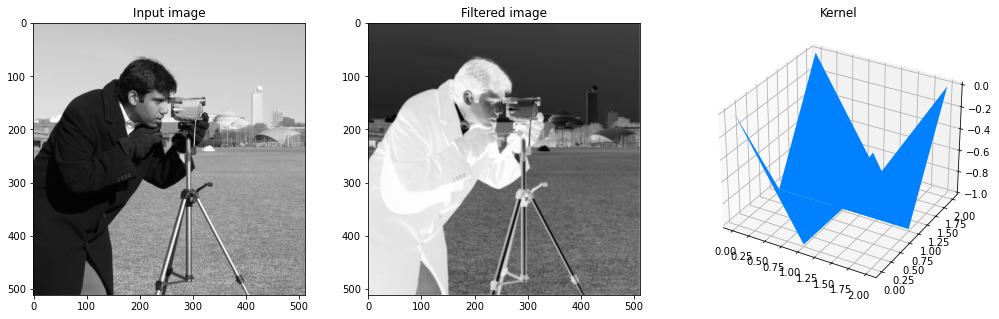

In [15]:
k = filtro_laplace(4)
img_filt = convolve2d(img, k, 'same')

plot_images_and_kernel(img, img_filt, k)

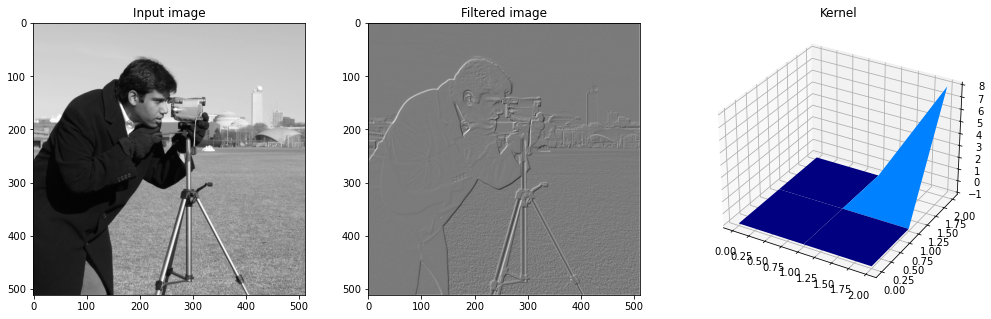

In [16]:
k = filtro_laplace(8)
img_filt = convolve2d(img, k, 'same')

plot_images_and_kernel(img, img_filt, k)

In [90]:
#Pasaaltos a partir de un pasabajos PA = Id - PB 

def filtro_pasaalto(N):
    
    PB = filtro_bartlett(N)
    pad_width= N//2-1
    
    Id = np.zeros((3,3))
    Id [1,1] = 1
    Id = np.pad(Id, pad_width)
    
   

    Kernel = Id-PB
    
    return PB

[[0.01234568 0.02469136 0.03703704 0.02469136 0.01234568]
 [0.02469136 0.04938272 0.07407407 0.04938272 0.02469136]
 [0.03703704 0.07407407 0.11111111 0.07407407 0.03703704]
 [0.02469136 0.04938272 0.07407407 0.04938272 0.02469136]
 [0.01234568 0.02469136 0.03703704 0.02469136 0.01234568]]


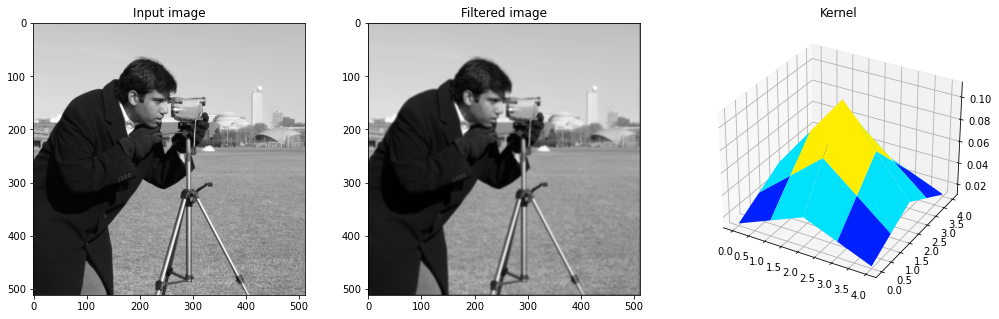

In [91]:
K = filtro_pasaalto(5)
print(k)
img_filt = convolve2d(img, K, 'same')

plot_images_and_kernel(img, img_filt, k)

In [18]:
#Pasabanda:

def filtro_DoG(N, std1, std2): 
    
    d1 = filtro_Gaussian(N,std1)
    d2 = filtro_Gaussian(N,std2)
    DoG = d1-d2
    return DoG

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]
[[0.01441882 0.02808402 0.0350727  0.02808402 0.01441882]
 [0.02808402 0.05470021 0.06831229 0.05470021 0.02808402]
 [0.0350727  0.06831229 0.08531173 0.06831229 0.0350727 ]
 [0.02808402 0.05470021 0.06831229 0.05470021 0.02808402]
 [0.01441882 0.02808402 0.0350727  0.02808402 0.01441882]]


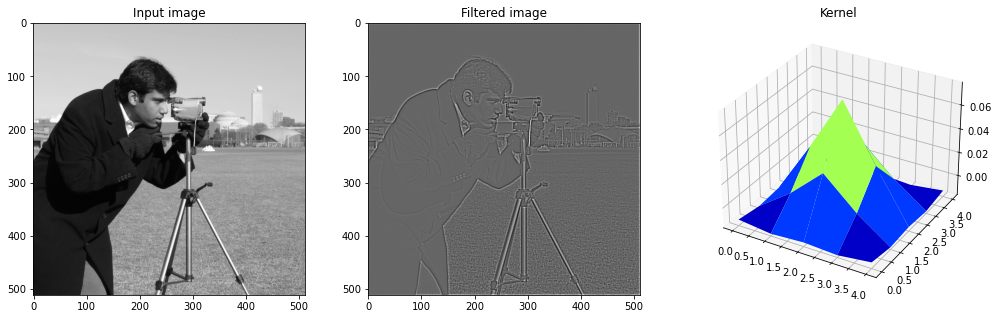

In [36]:
k= filtro_DoG(5, 1, 1.5)
img_filt = convolve2d(img, k, 'same')

plot_images_and_kernel(img, img_filt, k)

In [92]:
   
#Otros:

def filtro_contraste(N,alfa, Pa):
    
    Id = np.zeros((3,3))
    Id [1,1] = 1
    if N > 3:
        n=N//2-1
        Id = np.pad(Id,n)   
    print(Id)
    C = Id + alfa*Pa 
    return C
    





F1=np.arange(-8/2+1,8/2+1,1)
F1


array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


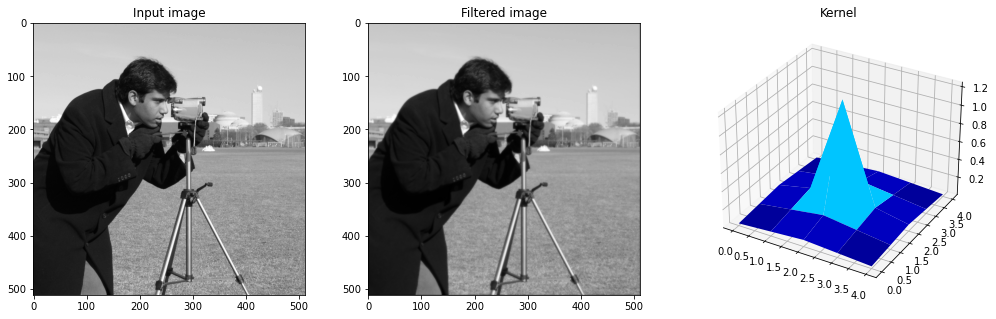

In [93]:

pa = filtro_pasaalto(5)
k = filtro_contraste(5, 2, pa)
img_filt = convolve2d(img, k, 'same')

plot_images_and_kernel(img, img_filt, k)

In [20]:
#Ejercicio 1.2: 


def filtro_sobel(g):
    if g == 1:
        kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])    
    elif g == 2: 
        kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) 
        
    return kernel 

Text(0.5, 1.0, 'Fase')

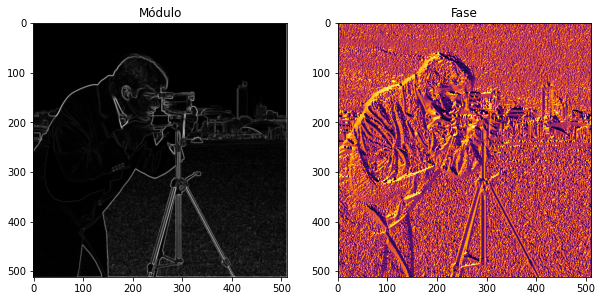

In [40]:

new_image_x = convolve2d(img, filtro_sobel(1) , 'same')          #Gx
new_image_y = convolve2d(img, filtro_sobel(2), 'same')           #Gy

Xm = np.abs(new_image_x)                                         # valor abs Gx
Ym = np.abs(new_image_y)                                         # valor abs Gy


gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))     # módulo del Gradiente
gradient_magnitude *=  1/ gradient_magnitude.max()  # normalizó entre [0,1]



                                                                 
gradient_phase = np.arctan2(new_image_x, new_image_y )   # Fase
gradient_phase = (gradient_phase + np.pi) / (2 * np.pi)    # normalizó entre [0,1] 
otsu = gradient_magnitude


_, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(gradient_magnitude, 'gray')
axes[0].set_title('Módulo')
axes[1].imshow(gradient_phase, 'inferno')
axes[1].set_title('Fase')




In [33]:
np.min(gradient_phase)
#np.max(gradient_phase)

0.0

Text(0.5, 1.0, 'Umbral al módulo del filtro de Sobel')

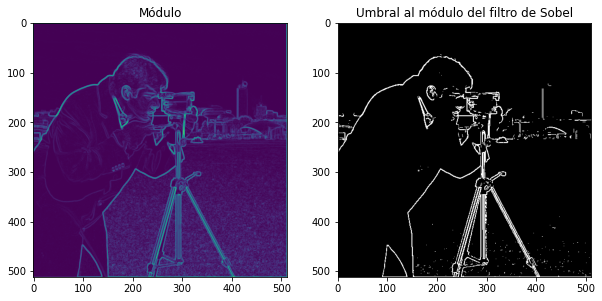

In [22]:
#Ejercicio 1.3

# umbral al módulo del filtro de Sobel para obtener una imagen binaria 
from skimage.filters import threshold_otsu
bin_otsu = otsu > threshold_otsu(otsu)



_, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(gradient_magnitude)
axes[0].set_title('Módulo')
axes[1].imshow(bin_otsu, 'gray')
axes[1].set_title('Umbral al módulo del filtro de Sobel')




 Ejercicio 1.4:  Detector de bordes de Canny


Primero vamos a definir que es un borde.Se lo puede definir como un cambio significativo en la intesidad. La detección de bordes tienen como utilidad en el procesamiento de imagenes para la extración  de caracteristicas importantes de un objeto, como tambien para deteminar el límite entre objetos.Uno de los métodos relacionados con la detección de bordes es el uso de la primera derivada, la que es usada por que toma el valor de cero en todas las regiones donde no varía la intensidad y tiene un valor constante en toda la transición de intensidad. Por tanto un cambio de intensidad  se manifiesta como un cambio brusco en la primera derivada, característica que es usada para detectar un borde, y en la que se basa el algoritmo de Canny.


El algoritmo de detección de bordes de Canny, fue desarrollado por John F. Canny en los 80s, el cual se basa en tres cirterios, estos son:
• Un criterio de detección expresa el hecho de evitar la eliminación de bordes 
importantes y no suministrar falsos bordes. 
• El criterio de localización establece que la distancia entre la posición real y la localizada 
del borde se debe minimizar. 
• El criterio de una respuesta que integre las respuestas múltiples correspondientes a un único borde. 


Canny logra optimizar la detección de bordes, ya que puede mantener una relación de compromiso entre el ruido y la localización de bordes. La implementación del método consiste en tres etapas principales:filtrado, decisión inicial, e histéresis.

• Filtrado:
Consiste en aplicar un filtro por convolución  de la derivada primera de una función de Gaussiana normalizado sobre una imagen. Realizado en la direcciones horizontales y verticales. Este filtrado se obtiene promediando los valores de intensidad de los píxels en el entorno de vecindad con una mascara de convolución de media cero y desviación estándar σ. 
Una vez que se suaviza la imagen, para cada píxel se obtiene la magnitud y módulo (orientación) del gradiente, obteniendo así dos imágenes.

• Decisión inicial:
Tambien conocido como supresión no máxima al resultado del gradiente, que sirve para generar una imagen con los bordes adelgazados. El procedimiento es el siguiente: se consideran cuatro direcciones  identificadas por las orientaciones de 0º, 45º, 90º y 135º con respecto al eje horizontal. Para cada  píxel se encuentra la dirección que mejor se aproxime a la dirección del ángulo de gradiente.Posteriormente se observa si el valor de la magnitud de gradiente es más pequeño que al menos 
uno de sus dos vecinos en la dirección del ángulo obtenida en el paso anterior. De ser así se asigna el valor 0 a dicho píxel, en caso contrario se asigna el valor que tenga la magnitud del gradiente.  


• Histéresis: 
El conjunto con los valores de gradiente que quedan es reducido de nuevo mediante un proceso denominado histéresis.Este proceso emplea dos umbrales. Si el valor de un píxel está por debajo del primer umbral, se clasifica como NO BORDE (etiqueta de 0 en 
imagen binaria). Aquellos píxeles cuyos valores superan el umbral más alto son clasificados como BORDE (etiqueta 1 en imagen binaria); y en el caso de que el valor de píxel se encuentre entre el umbral bajo y el alto, éste no es asignado como borde salvo que exista un camino entre este píxel y otro píxel cuyo gradiente sobrepase dicho umbral más alto.

